# Generate virtual observations

(Utiliser l'environnement *geo-env*)

Ce notebook présente comment générer des observations virtuelles uniquement sur la surface océanique

In [ ]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Ocean coordinates

In [ ]:
# Chargement d'un shapefile de la surface océanique
gdf_ocean = gpd.read_file("../_data/ne_50m_ocean.shp")
gdf_ocean = gdf_ocean.rename(index={0: 'ocean'})

In [11]:
def generate_ocean_coordinates(N, extent):
    """Generate N coordinates inside oceans"""
    lon_min, lon_max, lat_min, lat_max = extent
    gdf_points_N = gpd.GeoDataFrame()
    n=1
    # Par itération, on génère des points aléatoire et on vérifie s'ils sont à l'intérieur du shapefile
    while len(gdf_points_N) < N:
        #print(n)
        lon = np.random.uniform( lon_min, lon_max, N)
        lat = np.random.uniform( lat_min, lat_max, N)
        df = pd.DataFrame()
        df['points'] = list(zip(lon,lat))
        df['points'] = df['points'].apply(Point)
        gdf_points = gpd.GeoDataFrame(df, geometry='points')
        gdf_points = gdf_points.set_crs('EPSG:4326')
        Sjoin = gpd.tools.sjoin(gdf_points, gdf_ocean, predicate="within", how='left').dropna()
        gdf_points_N = pd.concat([gdf_points_N, Sjoin], ignore_index=True)
        #print(f"   {len(gdf_points_N)}")
        n+=1
    return gdf_points_N[['points']].head(N)

In [12]:
N = 10_000 # Nombre de points d'observations
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)

In [13]:
%%time
gdf = generate_ocean_coordinates(N, extent)

CPU times: user 420 ms, sys: 0 ns, total: 420 ms
Wall time: 445 ms


Text(0.5, 1.0, 'Coordonnées des observations')

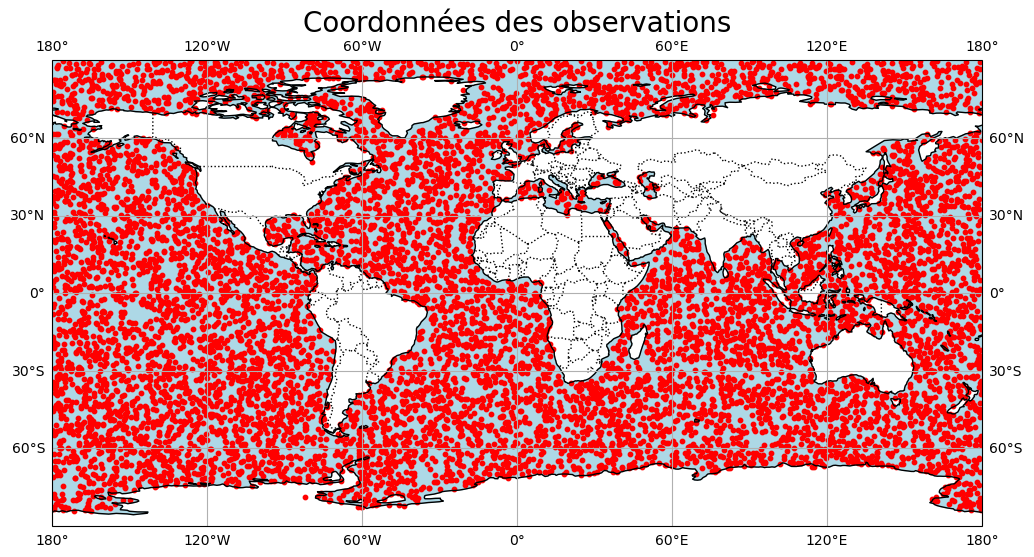

In [9]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.05, right=0.98, top=0.98, bottom=0.02)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
sc = gdf.plot(ax=ax, marker='o', color='red', markersize=10, label='Points')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.set_global()

plt.title(f'Coordonnées des observations', fontsize=20) 

Il est possible de récupérer les valeurs de longitude et latitude des points avec:

In [10]:
longitude, latitude = gdf.points.x.to_numpy(), gdf.points.y.to_numpy()

## Ocean observations

Pour obtenir des observations sur la surface océanique, il ne este plus qu'a ajouter à ces coordonnées une dimension temporelle.

In [35]:
def generate_ocean_observations(N, extent, period):
    """Generate N observations inside oceans"""
    obs = np.arange(0, N)
    start, end = period
    start_dt, end_dt = datetime.strptime(start, "%Y-%m-%d"), datetime.strptime(end, "%Y-%m-%d")
    time = np.array([start_dt + timedelta(days=np.random.randint(0, int((end_dt - start_dt).days))) for obs in range(N)])
    gdf = generate_ocean_coordinates(N, extent=extent)
    longitude, latitude = gdf.points.x.to_numpy(), gdf.points.y.to_numpy()
    return time, longitude, latitude, obs

In [36]:
N = 10 # Nombre de points d'observations
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)
period = ('2000-01-01','2001-01-01') # Extension temporelle (start_date, end_date)

In [37]:
# Génération des points d'observations
times, longitudes, latitudes, obs = generate_ocean_observations(N, extent, period)

In [38]:
observations = xr.Dataset(
    coords=dict(
        obs=obs,
        latitude=xr.DataArray(latitudes,  dims=["obs"]),
        longitude=xr.DataArray(longitudes,  dims=["obs"]),
        time=xr.DataArray(times,  dims=["obs"]),
    )
)

In [39]:
observations

<xarray.Dataset>
Dimensions:    (obs: 10)
Coordinates:
  * obs        (obs) int64 0 1 2 3 4 5 6 7 8 9
    latitude   (obs) float64 -5.22 88.87 -68.41 -50.9 ... -80.27 39.33 47.38
    longitude  (obs) float64 -97.64 110.2 38.75 -26.68 ... -40.49 -170.8 -10.92
    time       (obs) datetime64[ns] 2000-11-29 2000-11-12 ... 2000-11-02
Data variables:
    *empty*

### Fonction

In [1]:
import sys
sys.path.insert(0, '../..')
from histlib.observations import generate_virtual_observations

In [2]:
N = 10 # Nombre de points d'observations
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)
period = ('2000-01-01','2001-01-01') # Extension temporelle (start_date, end_date)

In [3]:
%%time
ds = generate_virtual_observations(N, extent, period)
ds

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 52.3 ms


<xarray.Dataset>
Dimensions:  (obs: 10)
Coordinates:
  * obs      (obs) int64 1 2 3 4 5 6 7 8 9 10
    lat      (obs) float64 85.46 30.63 -12.88 -55.86 ... 25.77 -32.8 46.93
    lon      (obs) float64 -107.8 -174.3 -106.5 96.92 ... -119.6 165.1 -32.91
    time     (obs) datetime64[ns] 2000-03-06 2000-03-12 ... 2000-03-31
Data variables:
    *empty*